# First implementation of Machine Learning Algorithm

In this file, we are going to import data from a file .csv that we take from chornograf.
We have to parse him and put into an array.
Finally we will insert some machin Learning algorithm with the librairy sklearn.

To do this, we will use some librairy as pandas, matplotlib, numpy, sklearn and some others.


In [11]:
from sklearn import linear_model
import csv
import math
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import random


Dans le fichier DataDemeterAll.csv

Toutes les données de puis 1970h à partir 7 mars au 28 mai

SELECT mean("temperature") AS "mean_temperature", mean("moisture-percent") AS "mean_moisture-percent"

FROM "demeter"."autogen"."chirp-left"

WHERE time > now() -2536h

GROUP BY time(30m) FILL(null)

# Import des données 

Leccture d'un fichier csv en un fichier dataframe.

Création d'une base dataframe avec comme colonne le temps, l'humidité, la tempérture, l'humidité + 1, la température + 1.

Il faut régler le problème tu dernier temps.

In [12]:
from traitement import Traitement


df = pd.read_csv('DataDemeter.csv')

t= Traitement()

#Création des deux autres colonnes
df = t.ajoutData(df)

## Ajout de l'arrosage

L'arrosage est ajouté au temps 10h30 ou 11h30.

In [13]:
import datetime

df = t.arrosageHist(df,1)
df['index'] = df.index
nligne = df.shape[0]
position = df.shape[1]-1
for i in range(nligne):
    df.iloc[i,position] = (i-6)//48 + 1
df.drop(df.index[df['index'] == 76], axis = 0, inplace = True)
df.drop(df.index[df['index'] == 75], axis = 0, inplace = True)
df.drop(df.index[df['index'] == 15], axis = 0, inplace = True)
df.drop(df.index[df['index'] == 102], axis = 0, inplace = True)
df.drop(df.index[df['index'] == 96], axis = 0, inplace = True)
df.drop(df.index[df['index'] == 97], axis = 0, inplace = True)
df.drop(df.index[df['index'] == 98], axis = 0, inplace = True)
df.drop(df.index[df['index'] == 41], axis = 0, inplace = True)



df

,date,mean_moisture-percent,mean_temperature,moistureAdd,temperatureAdd,Arrosage,TAfterArrosage,ArrosageHist,index
0,3/7/2019 7:30:00.000000000 AM,32.392593,25.083333,-0.142593,0.085000,0,0,0,0
1,3/7/2019 8:00:00.000000000 AM,32.250000,25.168333,-0.156667,0.126667,0,30,0,0
2,3/7/2019 8:30:00.000000000 AM,32.093333,25.295000,-0.078333,0.365000,0,60,0,0
3,3/7/2019 9:00:00.000000000 AM,32.015000,25.660000,-0.045000,-0.056667,0,90,0,0
4,3/7/2019 9:30:00.000000000 AM,31.970000,25.603333,-0.043333,0.071667,0,120,0,0
5,3/7/2019 10:00:00.000000000 AM,31.926667,25.675000,0.006667,0.138333,0,150,0,0
6,3/7/2019 10:30:00.000000000 AM,31.933333,25.813333,9.233333,-0.146667,10,0,10,1
7,3/7/2019 11:00:00.000000000 AM,41.166667,25.666667,-2.988333,0.676667,0,30,10,1
8,3/7/2019 11:30:00.000000000 AM,38.178333,26.343333,-1.380000,2.026667,0,60,10,1
9,3/7/2019 12:00:00.000000000 PM,36.798333,28.370000,-1.225000,4.456667,0,90,10,1


# Delete NaN Value

In [14]:
i = 6

df = t.eliminateNaNValue(df,i)
#Delete the data that are not inside a loop of one day
df.drop(df.index[range(0,i+48*3)],axis = 0,inplace = True)

nligne = df.shape[0]
print("nombre de ligne", nligne)
DF = df.copy()

nombre de ligne 4395


In [15]:
nligne = df.shape[0]
nColumn = df.shape[1]
print(df.isnull().sum())
for i in range(nligne):
    if df.iloc[i,:].isnull().values.any():
        print(df.index[i])
        

date                     0
mean_moisture-percent    0
mean_temperature         0
moistureAdd              0
temperatureAdd           0
Arrosage                 0
TAfterArrosage           0
ArrosageHist             0
index                    0
dtype: int64


# Data Test

Extraction des données aléatoire sur toutes les datasets. 7 jours entiers sont pris pour les tests.
Les données pour les Tests sont exclus des données pour le training

In [16]:
import random
jour = nligne //48
print("nb de jour totale : ",jour)
incr = 0
jourTest = random.sample(range(1,jour),k=14)
jourTest.sort()
print("jour de test : ",jourTest)


nb de jour totale :  91
jour de test :  [24, 25, 26, 32, 44, 46, 51, 53, 58, 59, 61, 63, 70, 82]


In [17]:
indTest = []
for el in jourTest:
    indTest = np.append(indTest,range(int(48*(el-1)),int(48*el)))
indTest = indTest.astype(int)
dataTest = df.iloc[indTest,:].copy()
DF = df.copy()
df.drop(df.index[indTest],axis = 0,inplace = True)


# Analyse de la dataFrame


## Linear Regression Multiple Variables sans l'information sur le temps sans arrosage



In [8]:
reg = linear_model.LinearRegression()
reg.fit(df[['mean_moisture-percent','mean_temperature','Arrosage']],df.moistureAdd)


LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [9]:
reg.coef_

array([-0.03005161, -0.019421  ,  0.22176613])

In [10]:
reg.intercept_

1.0251581227792657

In [11]:
reg.predict([[31,25,10]])[0]

1.8256943909707744

## Linear Regression Multiple Variables AVEC l'information sur le temps sans arrosage

In [28]:
reg2 = linear_model.LinearRegression()
reg2.fit(df[['mean_moisture-percent','mean_temperature','Arrosage','TAfterArrosage']],df.moistureAdd)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [13]:
reg2.coef_

array([ -2.23285590e-02,   1.65659008e-04,   2.28907800e-01,
         2.66809924e-04])

In [14]:
reg2.intercept_

0.15460452230171731

In [15]:
reg2.predict([[31,25,10,0]])[0]

1.7556386721032462



# Test avec data Test

On fait nos tests avec notre dataTest créé ci-dessus

## Test avec les donnes SANS le temps

In [16]:
init = 0+48*0
dataTest['resultSansT'] = dataTest.index
position = dataTest.shape[1]-1

StartHumidity = dataTest.iloc[init,1]
TestSize = dataTest.shape[0]
result = np.zeros(TestSize)
for i in range(0,TestSize):
    dataTest.iloc[int(i+init),position] = StartHumidity

    if i%48 == 0:
        StartHumidity = dataTest.iloc[init+i,1]
    result[i] = StartHumidity + reg.predict([[StartHumidity,dataTest.iloc[init+i,2],dataTest.iloc[init+i,5]]])[0]
    StartHumidity = result[i]
    

#print(dfTest.iloc[range(0+init+1,TestSize+init+1),1])
ErrSansTemps = np.mean(dataTest.iloc[:,1].values-dataTest.iloc[:,position].values)
ErrSansTempsAbs = np.mean(np.absolute(dataTest.iloc[:,1].values-dataTest.iloc[:,position].values))

print("Moyenne d'erreur : ",ErrSansTemps)
print("Moyenne d'erreur absolue : ",ErrSansTempsAbs)


Moyenne d'erreur :  -1.40881925166
Moyenne d'erreur absolue :  2.11946760129


## Test avec les donnes AVEC le temps

In [23]:
ErrTempsAbs7 = np.zeros(20)

for k in range(20):
    df = DF.copy()
    jour = nligne //48
    incr = 0
    jourTest = random.sample(range(1,jour),k=14)
    jourTest.sort()
    indTest = []
    for el in jourTest:
        indTest = np.append(indTest,range(int(48*(el-1)),int(48*el)))
    indTest = indTest.astype(int)
    dataTest = df.iloc[indTest,:].copy()
    df.drop(df.index[indTest],axis = 0,inplace = True)
    
    reg2 = linear_model.LinearRegression()
    reg2.fit(df[['mean_moisture-percent','mean_temperature','Arrosage','TAfterArrosage']],df.moistureAdd)
    init = 0+48*0
    dataTest['resultAvecT'] = dataTest.index
    position = dataTest.shape[1]-1

    StartHumidity = dataTest.iloc[init,1]

    TestSize = dataTest.shape[0]
    result2 = np.zeros(TestSize)
    for i in range(0,TestSize):
        dataTest.iloc[int(i+init),position] = StartHumidity

        if i%48 == 0:
            StartHumidity = dataTest.iloc[init+i,1]
        result2[i] = StartHumidity + reg2.predict([[StartHumidity,dataTest.iloc[init+i,2],dataTest.iloc[init+i,5],dataTest.iloc[init+i,6]]])[0]
        StartHumidity = result2[i]

    ErrTempsAbs7[k] = np.mean(np.absolute(dataTest.iloc[:,1].values-dataTest.iloc[:,position].values))
    
print("\n Moyenne d'erreur : ", np.mean(ErrTempsAbs7))


[-0.02113619  0.00319549  0.23562005  0.00029848 -0.00136788]
[ -2.48462576e-02  -3.41860001e-06   2.33447798e-01   2.77309406e-04
  -7.33836859e-04]
[-0.02117762  0.0034609   0.2319827   0.00029143 -0.00135023]
[-0.02233261  0.00273901  0.23143061  0.00029306 -0.00134068]
[-0.01953363  0.00725799  0.23485408  0.00031199 -0.00153934]
[-0.0201823   0.00428038  0.23108565  0.00029541 -0.0017244 ]
[-0.02079663 -0.00112823  0.23673806  0.00027154 -0.00211845]
[ -2.39078384e-02  -2.28169404e-05   2.32761071e-01   2.88577486e-04
  -9.69743367e-04]
[-0.02219248  0.00090206  0.23099726  0.00027397 -0.00132622]
[-0.02671446 -0.00044393  0.2350334   0.00026893 -0.00055254]
[-0.02022523  0.00264776  0.23228576  0.00029038 -0.00148276]
[-0.0266845   0.00117665  0.23177685  0.00027601 -0.00028082]
[-0.02163603 -0.00148465  0.22980724  0.00026446 -0.00190991]
[-0.02214669 -0.00211135  0.23937965  0.00026431 -0.00220792]
[-0.01991647  0.00311935  0.2288112   0.000288   -0.00185   ]
[-0.02115206  0.00

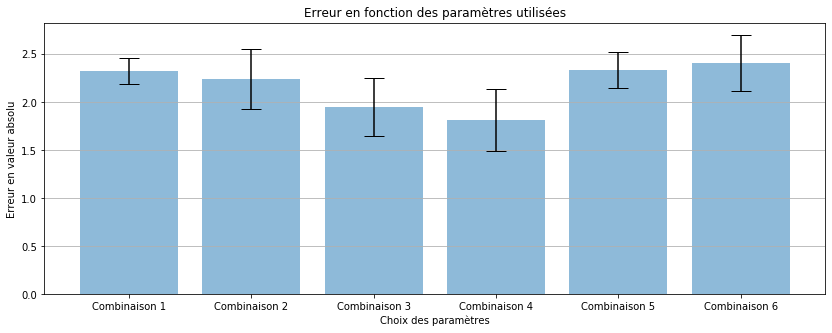

In [28]:
# x-coordinates of left sides of bars  

error = [np.std(ErrTempsAbs1), np.std(ErrTempsAbs2),np.std(ErrTempsAbs3),np.std(ErrTempsAbs4),np.std(ErrTempsAbs5),np.std(ErrTempsAbs6)]

left = [1, 2,3,4,5,6] 
  
# heights of bars 
height = [np.mean(ErrTempsAbs1),np.mean(ErrTempsAbs2),np.mean(ErrTempsAbs3),np.mean(ErrTempsAbs4),np.mean(ErrTempsAbs5),np.mean(ErrTempsAbs6)]
  
# labels for bars 
tick_label = ['Combinaison 1', 'Combinaison 2', 'Combinaison 3','Combinaison 4','Combinaison 5','Combinaison 6'] 

fig, ax = plt.subplots(figsize=(14,5)) # set the size that you'd like (width, height)
# plotting a bar chart 
ax.bar(left, height,
       yerr=error,
       align='center',
       alpha=0.5,
       ecolor='black',
       capsize=10)
#plt.bar(left, height, tick_label = tick_label, 
#        width = 0.8, color = ['red', 'blue']) 


ax.set_xticks(left)
ax.set_xticklabels(tick_label)
ax.set_title('Erreur en fonction des paramètres utilisées')
ax.yaxis.grid(True)
# naming the x-axis 
plt.xlabel('Choix des paramètres') 
# naming the y-axis 
plt.ylabel('Erreur en valeur absolu') 
# plot title 
  
# function to show the plot 
plt.show() 

# Gradient Boost Regression



In [32]:
import numpy as np
from sklearn.metrics import mean_squared_error
from sklearn.datasets import make_friedman1
from sklearn.ensemble import GradientBoostingRegressor

X, y = make_friedman1(n_samples=1200, random_state=0, noise=1.0)
X_train, X_test = X[:200], X[200:]
y_train, y_test = y[:200], y[200:]
est = GradientBoostingRegressor(n_estimators=100, learning_rate=0.1,
     max_depth=1, random_state=0, loss='ls').fit(df[['mean_moisture-percent','mean_temperature','Arrosage','TAfterArrosage']],df.moistureAdd)
res = est.predict(dataTest[['mean_moisture-percent','mean_temperature','Arrosage','TAfterArrosage']])
mean_squared_error(dataTest.moistureAdd, est.predict(dataTest[['mean_moisture-percent','mean_temperature','Arrosage','TAfterArrosage']])) 


0.084929571257836692

In [34]:
init = 0+48*0
dataTest['Boost'] = dataTest.index
position = dataTest.shape[1]-1

StartHumidity = dataTest.iloc[init,1]
TestSize = dataTest.shape[0]
result = np.zeros(TestSize)
for i in range(0,TestSize):
    dataTest.iloc[int(i+init),position] = StartHumidity

    if i%48 == 0:
        StartHumidity = dataTest.iloc[init+i,1]
    result[i] = StartHumidity + est.predict([[StartHumidity,dataTest.iloc[init+i,2],dataTest.iloc[init+i,5],dataTest.iloc[init+i,6]]])[0]
    StartHumidity = result[i]
    

#print(dfTest.iloc[range(0+init+1,TestSize+init+1),1])
ErrBoost = np.mean(dataTest.iloc[:,1].values-dataTest.iloc[:,position].values)
ErrBoostAbs = np.mean(np.absolute(dataTest.iloc[:,1].values-dataTest.iloc[:,position].values))

print("Moyenne d'erreur : ",ErrBoost)
print("Moyenne d'erreur absolue : ",ErrBoostAbs)

Moyenne d'erreur :  -0.312117472826
Moyenne d'erreur absolue :  0.762602032599


# Partage de la Data frame

Partage de la data frame en deux. 

Une partie qui contient que les moments où on arrose. On peut selectionner ceci grace à loc et à df['TAfterArrosage'] == 0. Quand on arrose, le temps après arrosage est de 0.

L'autre partie contient les moments où on n'arrose pas. C'est-à-dire les momments où l'eau s'évapore.

In [80]:
limite = 240
dfArrosage = df.loc[df['TAfterArrosage'] == 0]
tmp = df.loc[df['TAfterArrosage'] > 0]
dfStabilisation = df.loc[df['TAfterArrosage'] > limite].copy()
dfEvaporation = tmp.loc[df['TAfterArrosage'] <= limite].copy()

In [81]:
regLinearAro = linear_model.LinearRegression()
regLinearAro.fit(dfArrosage[['mean_moisture-percent','Arrosage']],dfArrosage.moistureAdd)
regLinearAro.intercept_
regLinearAro.coef_
#regLinearAro= GradientBoostingRegressor(n_estimators=20, learning_rate=0.1,
 #    max_depth=1, random_state=0, loss='ls').fit(dfArrosage[['mean_moisture-percent','Arrosage']],dfArrosage.moistureAdd)

array([-0.03764011,  0.00508593])

In [82]:
# Pour faire le régression linear sur le moment d'arrosage
regLinearEva = linear_model.LinearRegression()
regLinearEva.fit(dfEvaporation[['mean_moisture-percent','mean_temperature','TAfterArrosage','ArrosageHist']],dfEvaporation.moistureAdd)
regLinearEva.intercept_
regLinearEva.coef_
#regLinearEva = GradientBoostingRegressor(n_estimators=50, learning_rate=0.1,
 #    max_depth=1, random_state=0, loss='ls').fit(dfEvaporation[['mean_moisture-percent','mean_temperature','Arrosage','TAfterArrosage']],dfEvaporation.moistureAdd)

array([-0.01887533, -0.05666651,  0.00881193,  0.000452  ])

In [83]:
# Pour faire le régression linear sur le moment d'arrosage
regLinearSta = linear_model.LinearRegression()
regLinearSta.fit(dfStabilisation[['mean_moisture-percent','mean_temperature','TAfterArrosage','ArrosageHist']],dfStabilisation.moistureAdd)
regLinearSta.intercept_
regLinearSta.coef_
#regLinearSta = GradientBoostingRegressor(n_estimators=50, learning_rate=0.1,
 #    max_depth=1, random_state=0, loss='ls').fit(dfStabilisation[['mean_moisture-percent','mean_temperature','Arrosage','TAfterArrosage']],dfStabilisation.moistureAdd)

array([ -4.04521344e-03,   5.19817488e-03,   1.58323395e-05,
         7.60960623e-04])

In [84]:
#Pour tester sur la base de données de training
init = 0
base = dataTest 


In [85]:
dataTest['resultSepare'] = dataTest.index
StartHumidity = base.iloc[init,1]
position = dataTest.shape[1]-1


TestSize = dataTest.shape[0]
ErrAro = 0
result = np.zeros(TestSize)
ErrEva = 0
nAro = 0

for i in range(0,TestSize-1):
    dataTest.iloc[int(i),position] = StartHumidity

    if dataTest.iloc[i,6] == 0:
        nAro =+ 1
        StartHumidity = dataTest.iloc[i,1]
        result[i] = StartHumidity + regLinearAro.predict([[StartHumidity,base.iloc[init+i,5]]])[0]
        ErrAro =+ abs(result[i] - base.iloc[i+1,1])
    elif dataTest.iloc[i,6] <= limite:
        result[i] = StartHumidity + regLinearEva.predict([[StartHumidity,base.iloc[init+i,2],base.iloc[init+i,6],base.iloc[init+i,7]]])[0]
        ErrEva =+ abs(result[i] - base.iloc[i+1,1])
    else:
        result[i] = StartHumidity + regLinearSta.predict([[StartHumidity,base.iloc[init+i,2],base.iloc[init+i,6],base.iloc[init+i,7]]])[0]
        ErrSta =+ abs(result[i] - base.iloc[i+1,1])

    StartHumidity = result[i]
dataTest.iloc[TestSize-1,position] = StartHumidity

ErrAro = ErrAro/nAro
ErrEva = ErrEva/(15*nAro)
ErrSta = ErrSta/((48-16*nAro))

print("Moyenne Erreur d'Arrosage : ", ErrAro)
print("Moyenne d'erreur evaporation : ", ErrEva)
print("Moyenne d'erreur stabilisation : ", ErrSta)

ErrSepare = np.mean(dataTest.iloc[:,1].values-dataTest.iloc[:,position].values)
ErrSepareAbs = np.mean(np.absolute(dataTest.iloc[:,1].values-dataTest.iloc[:,position].values))
print("Moyenne d'erreur : ",ErrSepare)
print("Moyenne d'erreur absolue : ",ErrSepareAbs)


Moyenne Erreur d'Arrosage :  1.21077989054
Moyenne d'erreur evaporation :  0.122602863606
Moyenne d'erreur stabilisation :  0.054079024148
Moyenne d'erreur :  -0.194583976284
Moyenne d'erreur absolue :  0.985107075975


In [76]:
dataTest

,date,mean_moisture-percent,mean_temperature,moistureAdd,temperatureAdd,Arrosage,TAfterArrosage,ArrosageHist,index,Boost,resultSepare
1350,4/4/2019 11:30:00.000000000 AM,14.816667,25.016667,5.441667e+00,-1.571667,20,0,20,29,14.816667,14.816667
1351,4/4/2019 12:00:00.000000000 PM,20.258333,23.445000,-1.881667e+00,0.913333,0,30,20,29,21.477405,21.765073
1352,4/4/2019 12:30:00.000000000 PM,18.376667,24.358333,-6.650000e-01,0.470000,0,60,20,29,19.603316,19.204390
1353,4/4/2019 1:00:00.000000000 PM,17.711667,24.828333,-4.150000e-01,0.600000,0,90,20,29,19.037118,16.643707
1354,4/4/2019 1:30:00.000000000 PM,17.296667,25.428333,-4.066667e-01,1.718333,0,120,20,29,18.561805,14.056978
1355,4/4/2019 2:00:00.000000000 PM,16.890000,27.146667,-2.600000e-01,0.093333,0,150,20,29,18.191967,11.470249
1356,4/4/2019 2:30:00.000000000 PM,16.630000,27.240000,-3.700000e-01,1.250000,0,180,20,29,17.822129,8.883520
1357,4/4/2019 3:00:00.000000000 PM,16.260000,28.490000,-3.400000e-01,0.360000,0,210,20,29,17.452290,6.296791
1358,4/4/2019 3:30:00.000000000 PM,15.920000,28.850000,-9.600000e-01,5.941667,0,240,20,29,17.082452,3.710062
1359,4/4/2019 4:00:00.000000000 PM,14.960000,34.791667,-2.333333e-01,-0.546667,0,270,20,29,16.838086,1.123333


In [25]:
# x-coordinates of left sides of bars  
left = [1, 2, 3, 4, 5] 
  
# heights of bars 
height = [ErrSepareAbs5,ErrSepareAbs4, ErrSepareAbs3, ErrSepareAbs2,ErrSepareAbs1]
height = [abs(x) for x in height]

f, ax = plt.subplots(figsize=(10,5)) # set the size that you'd like (width, height)
# labels for bars 
tick_label = ['Temp+Moist', 'Temp+Moist+Temps', 'T+M+Arro','T+M+Arro+Temps','All'] 
  
# plotting a bar chart 
plt.bar(left, height, tick_label = tick_label,
        width = 0.8, color = ['blue', 'green']) 

# naming the x-axis 
plt.xlabel('Paramètre choisi') 
# naming the y-axis 
plt.ylabel('Erreur absolu') 
# plot title 
plt.title('Erreur suivant les paramètres utilisés') 
  
# function to show the plot 
plt.show() 

NameError: name 'ErrSepareAbs5' is not defined

# Affichage des résultats

On Affiche les resultats

In [26]:
print("Sans le temps : ", ErrSansTemps)
print("Sans le temps absolue : ", ErrSansTempsAbs)

print("\nAvec le temps : ", ErrTemps)
print("Avec le temps absolu : ", ErrTempsAbs)


#print("\nDurant Arrosage : ",ErrAro)
#print("Evaporation : " , ErrEva)
print("\nAvec Temps Séparé : ", ErrSepare)
print("Avec Temps Séparé absolu : ", ErrSepareAbs)


Sans le temps :  -1.40881925166
Sans le temps absolue :  2.11946760129

Avec le temps :  -0.666742821506
Avec le temps absolu :  1.47344051767

Avec Temps Séparé :  -0.596006310148
Avec Temps Séparé absolu :  1.05914013775


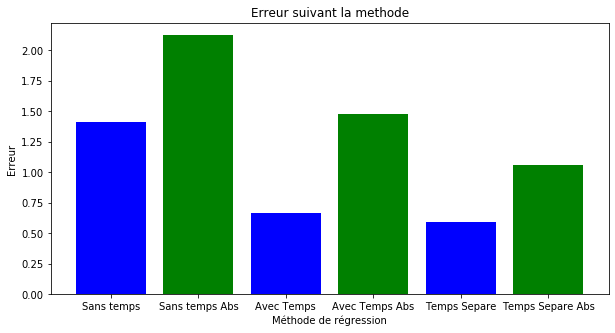

In [27]:
# x-coordinates of left sides of bars  
left = [1, 2, 3, 4, 5, 6] 
  
# heights of bars 
height = [ErrSansTemps,ErrSansTempsAbs, ErrTemps, ErrTempsAbs, ErrSepare,ErrSepareAbs]
height = [abs(x) for x in height]

  
# labels for bars 
tick_label = ['Sans temps', 'Sans temps Abs', 'Avec Temps','Avec Temps Abs', 'Temps Separe','Temps Separe Abs'] 
f, ax = plt.subplots(figsize=(10,5)) # set the size that you'd like (width, height)

# plotting a bar chart 
plt.bar(left, height, tick_label = tick_label,
        width = 0.8, color = ['blue', 'green']) 

# naming the x-axis 
plt.xlabel('Méthode de régression') 
# naming the y-axis 
plt.ylabel('Erreur') 
# plot title 
plt.title('Erreur suivant la methode') 
  
# function to show the plot 
plt.show() 

# Graphic

Creation des graphics de la courbe d'évolution de la température



Text(0, 0.5, 'Watering quantity')

<Figure size 432x288 with 0 Axes>

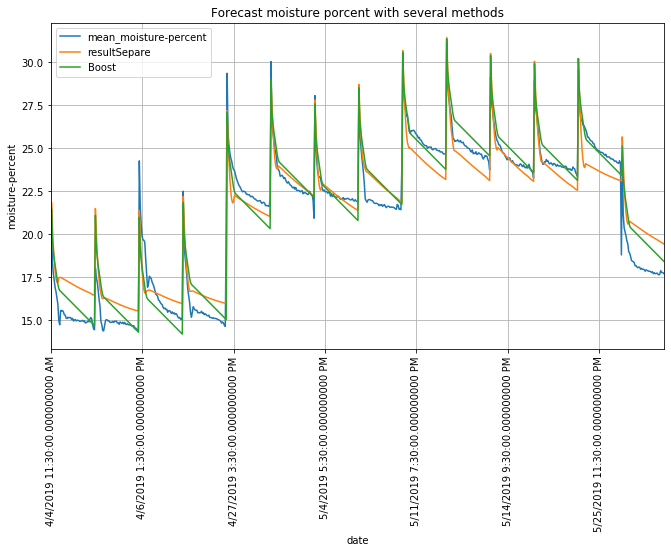

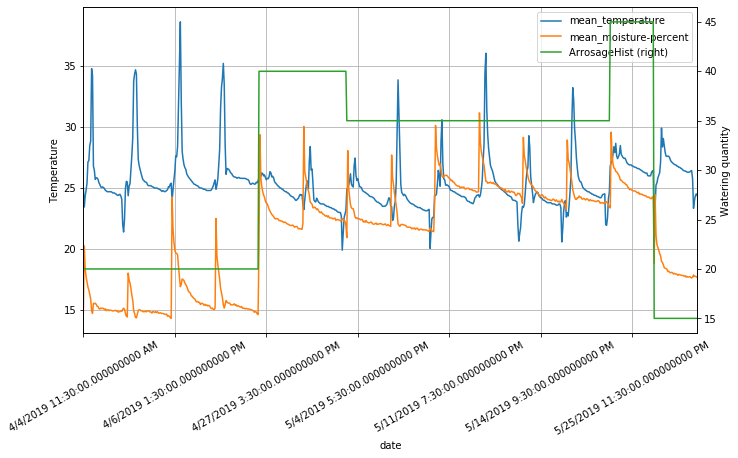

In [87]:
fig = plt.figure()
ax = dataTest.plot(x='date', y=['mean_moisture-percent','resultSepare','Boost'],figsize=(11, 6),rot=90,grid=True, title="Forecast moisture porcent with several methods")
ax.set_ylabel("moisture-percent")

ax = dataTest.plot(x='date', y=['mean_temperature','mean_moisture-percent','ArrosageHist'],secondary_y=['ArrosageHist'],figsize=(11, 6),rot=30,grid=True)

ax.set_ylabel("Temperature")
ax.right_ax.set_ylabel('Watering quantity')


#dfTest.loc[dfTest['TAfterArrosage'] == 30]

## recherche de la meilleures delimitation pour le partitionnement en 3



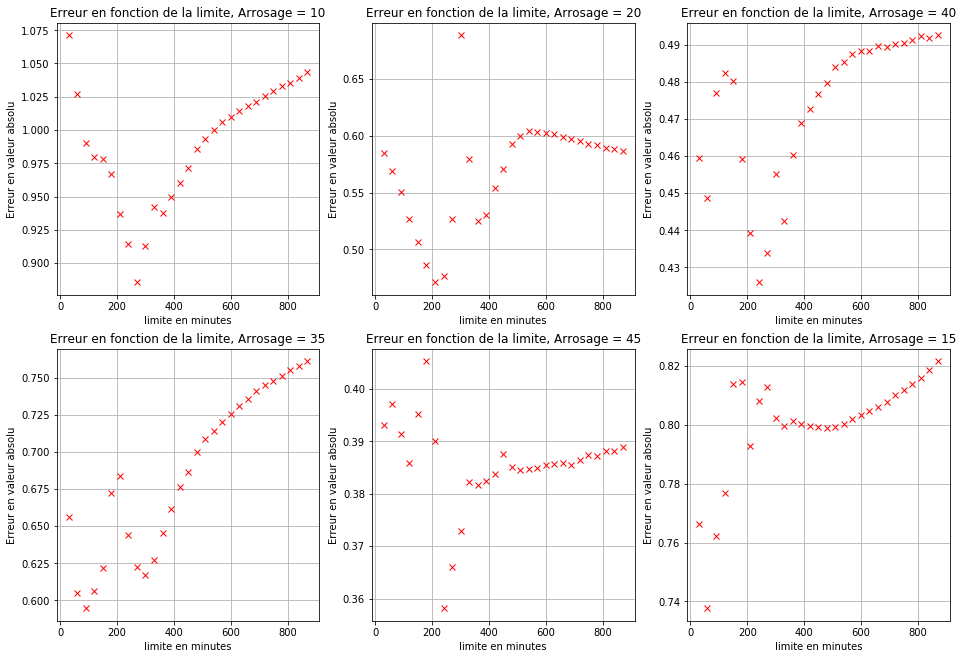

In [29]:
j = 1
f, ax = plt.subplots(figsize=(16,11))
for ARRO in [10,20,40,35,45,15]:
    dfarro = DF.loc[DF['ArrosageHist'] == ARRO]
    dfArrosage = dfarro.loc[dfarro['TAfterArrosage'] == 0]
    tmp = dfarro.loc[dfarro['TAfterArrosage'] > 0]

    bestLimite = 0
    errmin = 1000
    res = np.zeros(900//30-1)
    for limite in range(30,900,30):

        dfStabilisation = dfarro.loc[dfarro['TAfterArrosage'] > limite].copy()
        dfEvaporation = tmp.loc[dfarro['TAfterArrosage'] <= limite].copy()

        regLinearAro = linear_model.LinearRegression()
        regLinearAro.fit(dfArrosage[['mean_moisture-percent','Arrosage','index']],dfArrosage.moistureAdd)
        regLinearEva = linear_model.LinearRegression()
        regLinearEva.fit(dfEvaporation[['mean_moisture-percent','mean_temperature','TAfterArrosage','ArrosageHist','index']],dfEvaporation.moistureAdd)
        regLinearSta = linear_model.LinearRegression()
        regLinearSta.fit(dfStabilisation[['mean_moisture-percent','mean_temperature','TAfterArrosage','ArrosageHist','index']],dfStabilisation.moistureAdd)


        databasetest = dfarro.copy()
        databasetest['resultSepare'] = databasetest.index
        StartHumidity = databasetest.iloc[0,1]
        position = databasetest.shape[1]-1
        TestSize = databasetest.shape[0]
        result = np.zeros(TestSize)

        for i in range(0,TestSize-1):
            databasetest.iloc[int(i),position] = StartHumidity

            if databasetest.iloc[i,6] == 0:
                StartHumidity = databasetest.iloc[i,1]
                result[i] = StartHumidity + regLinearAro.predict([[StartHumidity,databasetest.iloc[i,5],databasetest.iloc[i,8]]])[0]
            elif databasetest.iloc[i,6] <= limite:
                result[i] = StartHumidity + regLinearEva.predict([[StartHumidity,databasetest.iloc[i,2],databasetest.iloc[i,6],databasetest.iloc[i,7],databasetest.iloc[i,8]]])[0]
            else:
                result[i] = StartHumidity + regLinearSta.predict([[StartHumidity,databasetest.iloc[i,2],databasetest.iloc[i,6],databasetest.iloc[i,7],databasetest.iloc[i,8]]])[0]

            StartHumidity = result[i]
        databasetest.iloc[TestSize-1,position] = StartHumidity


        ErrSepare = np.mean(databasetest.iloc[:,1].values-databasetest.iloc[:,position].values)
        ErrSepareAbs = np.mean(np.absolute(databasetest.iloc[:,1].values-databasetest.iloc[:,position].values))
        res[limite//30-1]=ErrSepareAbs
        if (ErrSepareAbs< errmin):
            bestLimite = limite
            errmin = ErrSepareAbs
    
    #print("BEST LIMITE pour un arrosage de ", ARRO ," : ",bestLimite)
    plt.subplot(2,3,j)
    plt.grid(b = True)
    plt.plot(range(30,900,30), res, 'rx')
    plt.xlabel('limite en minutes')
    plt.ylabel('Erreur en valeur absolu')
    plt.title('Erreur en fonction de la limite, Arrosage = '+str(ARRO))
    j = j + 1
plt.show()


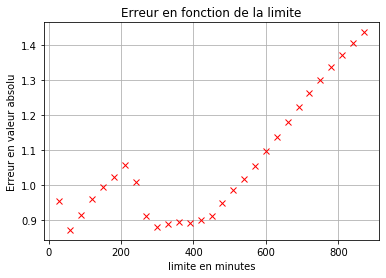

In [18]:
dfarro = df.copy()
dfArrosage = dfarro.loc[dfarro['TAfterArrosage'] == 0]
tmp = dfarro.loc[dfarro['TAfterArrosage'] > 0]

bestLimite = 0
errmin = 1000
res = np.zeros(900//30-1)
for limite in range(30,900,30):

    dfStabilisation = dfarro.loc[dfarro['TAfterArrosage'] > limite].copy()
    dfEvaporation = tmp.loc[dfarro['TAfterArrosage'] <= limite].copy()

    regLinearAro = linear_model.LinearRegression()
    regLinearAro.fit(dfArrosage[['mean_moisture-percent','Arrosage','index']],dfArrosage.moistureAdd)
    regLinearEva = linear_model.LinearRegression()
    regLinearEva.fit(dfEvaporation[['mean_moisture-percent','mean_temperature','TAfterArrosage','ArrosageHist','index']],dfEvaporation.moistureAdd)
    regLinearSta = linear_model.LinearRegression()
    regLinearSta.fit(dfStabilisation[['mean_moisture-percent','mean_temperature','TAfterArrosage','ArrosageHist','index']],dfStabilisation.moistureAdd)


    databasetest = dataTest.copy()
    databasetest['resultSepare'] = databasetest.index
    StartHumidity = databasetest.iloc[0,1]
    position = databasetest.shape[1]-1
    TestSize = databasetest.shape[0]
    result = np.zeros(TestSize)

    for i in range(0,TestSize-1):
        databasetest.iloc[int(i),position] = StartHumidity

        if databasetest.iloc[i,6] == 0:
            StartHumidity = databasetest.iloc[i,1]
            result[i] = StartHumidity + regLinearAro.predict([[StartHumidity,databasetest.iloc[i,5],databasetest.iloc[i,8]]])[0]
        elif databasetest.iloc[i,6] <= limite:
            result[i] = StartHumidity + regLinearEva.predict([[StartHumidity,databasetest.iloc[i,2],databasetest.iloc[i,6],databasetest.iloc[i,7],databasetest.iloc[i,8]]])[0]
        else:
            result[i] = StartHumidity + regLinearSta.predict([[StartHumidity,databasetest.iloc[i,2],databasetest.iloc[i,6],databasetest.iloc[i,7],databasetest.iloc[i,8]]])[0]

        StartHumidity = result[i]
    databasetest.iloc[TestSize-1,position] = StartHumidity


    ErrSepare = np.mean(databasetest.iloc[:,1].values-databasetest.iloc[:,position].values)
    ErrSepareAbs = np.mean(np.absolute(databasetest.iloc[:,1].values-databasetest.iloc[:,position].values))
    res[limite//30-1]=ErrSepareAbs
    if (ErrSepareAbs< errmin):
        bestLimite = limite
        errmin = ErrSepareAbs

#print("BEST LIMITE pour un arrosage de ", ARRO ," : ",bestLimite)
plt.grid(b = True)
plt.plot(range(30,900,30), res, 'rx')
plt.xlabel('limite en minutes')
plt.ylabel('Erreur en valeur absolu')
plt.title('Erreur en fonction de la limite')
plt.show()


,date,mean_moisture-percent,mean_temperature,moistureAdd,temperatureAdd,Arrosage,TAfterArrosage,ArrosageHist,index
1906,4/16/2019 1:30:00.000000000 AM,14.640000,26.000000,-0.010000,0.000000,0,840,20,40
1907,4/16/2019 2:00:00.000000000 AM,14.630000,26.000000,-0.066667,-0.013333,0,870,20,40
1908,4/16/2019 2:30:00.000000000 AM,14.563333,25.986667,0.013333,-0.051667,0,900,20,40
1909,4/16/2019 3:00:00.000000000 AM,14.576667,25.935000,-0.070000,-0.035000,0,930,20,40
1910,4/16/2019 3:30:00.000000000 AM,14.506667,25.900000,0.020000,0.000000,0,960,20,40
1911,4/16/2019 4:00:00.000000000 AM,14.526667,25.900000,-0.020000,0.000000,0,990,20,40
1912,4/16/2019 4:30:00.000000000 AM,14.506667,25.900000,-0.066667,-0.048333,0,1020,20,40
1913,4/16/2019 5:00:00.000000000 AM,14.440000,25.851667,0.010000,-0.035000,0,1050,20,40
1914,4/16/2019 5:30:00.000000000 AM,14.450000,25.816667,-0.020000,-0.016667,0,1080,20,40
1915,4/16/2019 6:00:00.000000000 AM,14.430000,25.800000,-0.006667,0.000000,0,1110,20,40


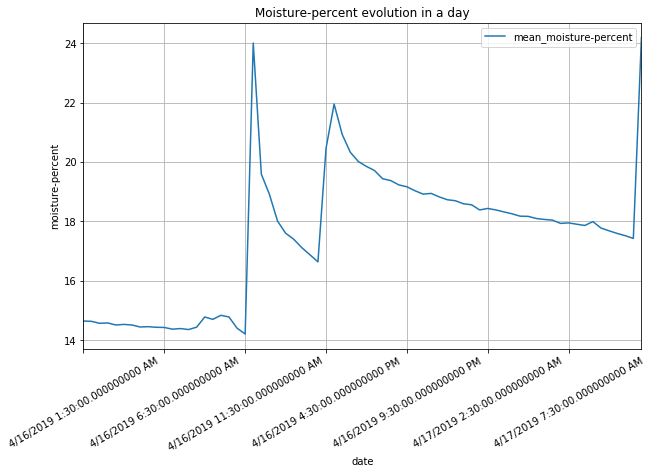

In [44]:
dfGraph = DF.iloc[range(1660,1730),:]
ax = dfGraph.plot(x='date', y=['mean_moisture-percent'],figsize=(10, 6),rot=30,grid=True, title="Moisture-percent evolution in a day")
ax.set_ylabel("moisture-percent")

# Erreur après 24heures

L'erreur ci-dessous représente l'erreur à la dernière itération.

In [134]:
dfEnd = dataTest.loc[dataTest['TAfterArrosage'] == 0]
EndSans = np.mean(dfEnd.iloc[:,8]-dfEnd.iloc[:,1])
EndAvec = np.mean(dfEnd.iloc[:,9]-dfEnd.iloc[:,1])
EndSepare = np.mean(dfEnd.iloc[:,10]-dfEnd.iloc[:,1])

print("Sans le temps : ", EndSans)
print("Avec le temps : ", EndAvec)
print("Avec Temps Séparé : ", EndSepare)


Sans le temps :  22.6970238095
Avec le temps :  -0.192043816914
Avec Temps Séparé :  -0.116894436181




## Essaie avec d'autre méthode